In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pickle

Create a colourful hat
Most colourful hat wins
One person must wear it for the remainder of the evening.
You have 5 minutes


**Experimental methods**

Our goal is to find out how the performance of models change as they get more difficult to simulate classically. Under the divide and conquer scheme we cut two-qubit gates in order to partition a model into blocks containing fewer qubits. The scaling of the resulting algorithm is as follows: $\mathcal{O}(2^{K+n}B)$, where $K$ is the number of two-qubit gates that are cut, $n$ the number of qubits in the largest block and $B$ the number of blocks. In order to avoid having to solve the combinatorially hard task of finding the optimal cuts for any arbitrary circuit, we predefine a circuit with a set number of blocks, each with the same number of qubits, and introduce the cut two-qubit gates as a design choice. This allows for a more refined control of the difficulty of the simulation. From the scaling it is evident that simulatability is mainly a tradeoff between the number of cut gates, and the number of qubits in each block. 
In the remainder of this notebook we go through important experiment design choices, and justify our decisions for each.


*Number of blocks $B$, qubits $n$ and cuts $K$* <br>
In order to maintain the possibility of full qubit connectivity/entanglement (such as in Fig 1), it is reasonable to generally relate the number of cut gates to the number of blocks. For example, in order to achieve a ring of qubit connectivity, one would need as many cut gates as blocks, ie $K=B$. As long as we make this demand, this is a restriction on the number of blocks as $K$ contributes to the exponential scaling. We would like to use our D&C method to go beyond the limits of brute force full circuit simulation, which we can set at 15 qubits as a conservative estimate, such that we want $Bn\ge15$. <br>
During testing we find the upper limit of the hardware to be around $(K=8, n=5) $ or $ (K=0, n=12)$. *We choose to fix $n=5$* for most experiments as this allows for a good range of $K$'s to be tested. We vary $B$ as desired, but aim to set it at 4 for the final experiments such that we end up with a 20 qubit classifier, which is larger than most models seen in related literature.

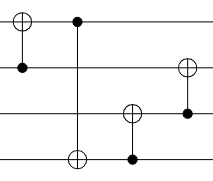
<br> Fig 1. An example of a ring of CNOTs leading to full qubit entanglement.

*Block ansatz* <br>
We elect to go with a hardware efficient ansatz as the gate set is native to many NISQ devices (A. Kandala et al., Nature, 2017). A circuit diagrammatic representation is shown below in Fig 2. It can readily be generalized to $n$ qubits, and the gates highlighted in the blue box can be repeated for multiple "layers", before the last set of single qubit rotations. These are arbitrary rotations, implemented as $R_{z}(\alpha_{j})R_{y}(\beta_{j})R_{z}(\gamma_{j})$. We assign each data point one qubit and vice versa. These are uploaded through a parameterized $R_{x}$ gate. We use parameterized $R_{z}$ and $R_{y}$ gates to introduce as these do not commute with the data uploading gates. The qubits are entangled using the CNOT gate, which has no free parameters. For convenience let us define $U_{l}(\theta, x)$ as the $l$th repetition of the gates in the blue box below. The action of our block ansatz with $L$ layers can be expressed as $W(\Theta, x,L)|\psi\rangle=(\prod_{i}^{L}U_{i}(\theta_{i},x))V|\psi\rangle$ where $V$ is the unitary containing the single qubit rotations preceding the measurement, $|\psi\rangle$ some fiducial state and $\bigcup_{i}\theta_{i} = \Theta \in [-\pi/2, \pi/2]^{N_{P}}$, with $N_{P}=3(L+1)n$ is the total number of parameters in the model. 

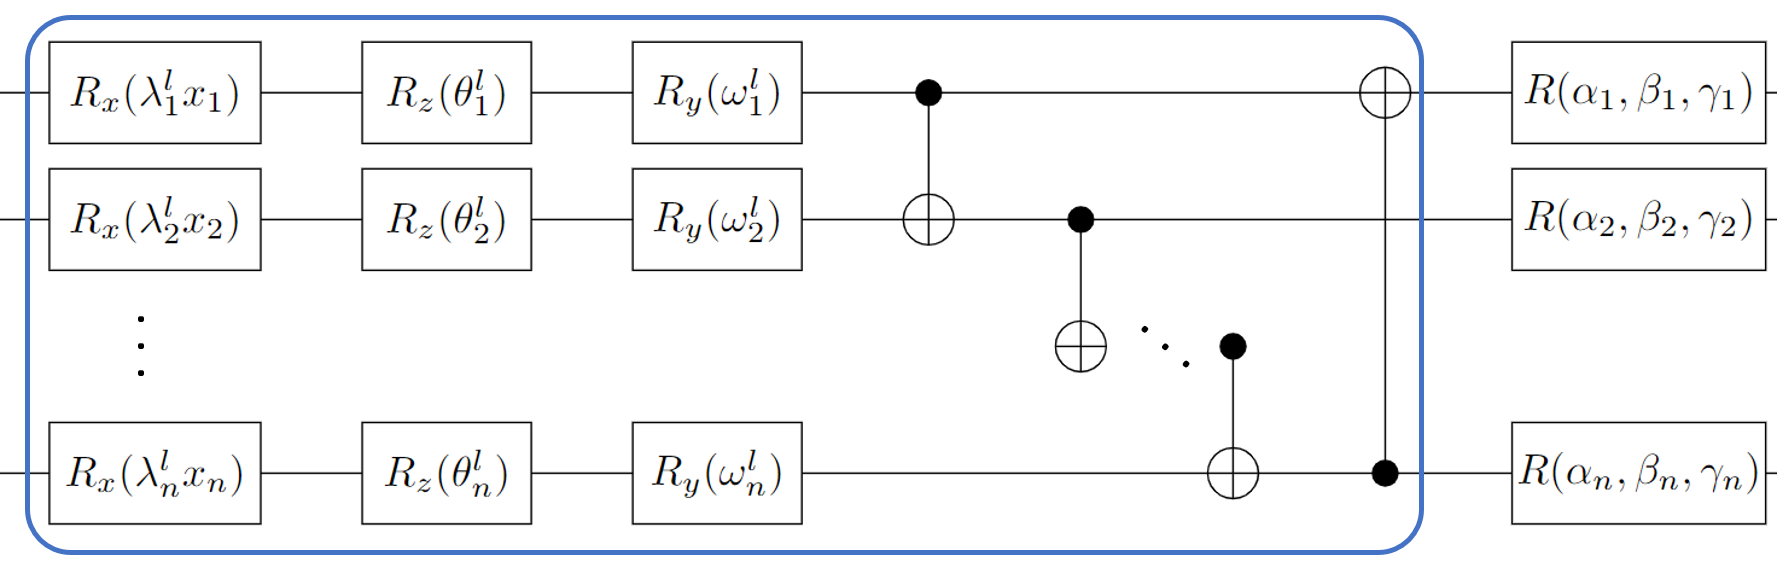
Fig 2. The Hardware Efficient Ansatz (HEA) used in this report. The gates in the blue box can be repeated multiple times for increased expressivity. Here the subscripts identify the qubit and the superscript the layer in which a certain parameter appears.

*Circuit Ansatz* <br>
The overall circuit ansatz is a contructed from the block ansatz, the CNOTs connecting the blocks and an obervable. 
Starting with the CNOTs connecting blocks, we highlight our method of placement in Fig 3 below. Each qubit line now represents one block of $n$ qubits as in Fig 2, within which two-qubit gates do not cost any additional resources. Each CNOT (acting across block partitions) has the last qubit in the control block as the control qubit, and the first qubit in the target block is the target qubit. Since the intra-block CNOTs act before the inter-block CNOTs, the structure is not exactly ring like, and only for $L>1$ gives full qubit connectivity. Our choice of observable is Pauli-Z. We empirically test the difference between a Pauli-Z on all-qubits and on the last qubit of each block below.

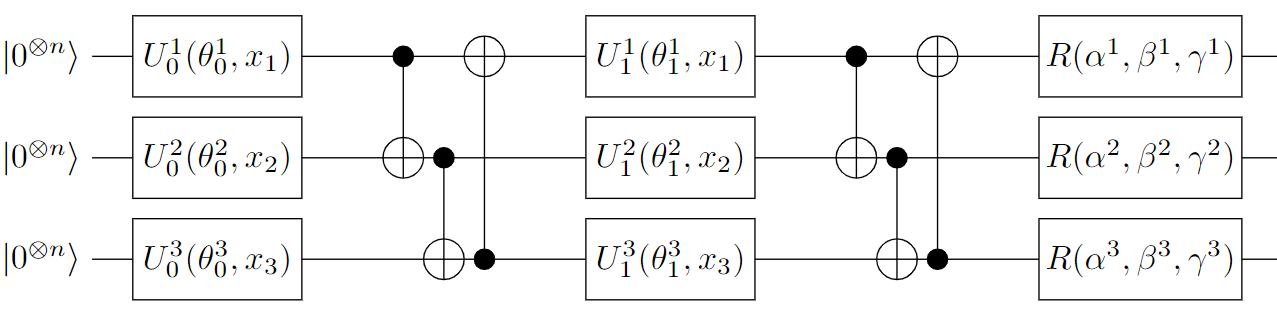
Fig 3. Circuit diagram of the model used in this report, with 2 layers and $K=6$ cut CNOTs. Each $U^{P_{i}}_{l}$ is one layer as shown in the blue box in Fig 2. The CNOTs displayed are simulated using the gate cutting technique. Here the superscripts identify the partition the unitary acts on and the subscript the layer index.

We first show plots of the training and validation accuracy to assess convergence or overfitting.Later we will better present the differences.
Results for the first 10 epochs are omitted to reduce the y-axis range.
The models below have entanglement between blocks as in Fig 3 but with a number of layers as stated.


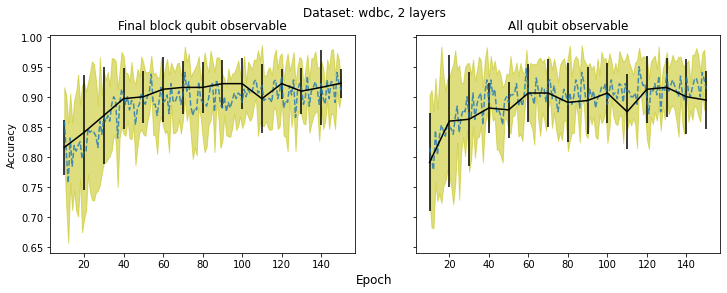

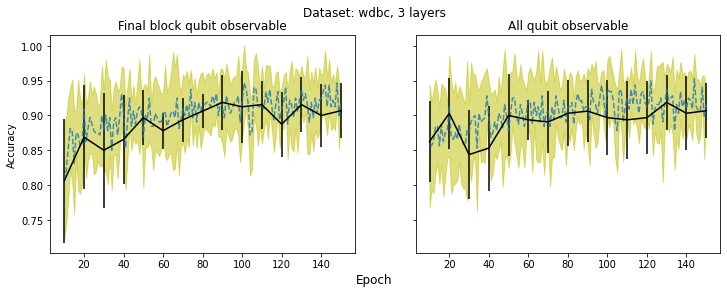

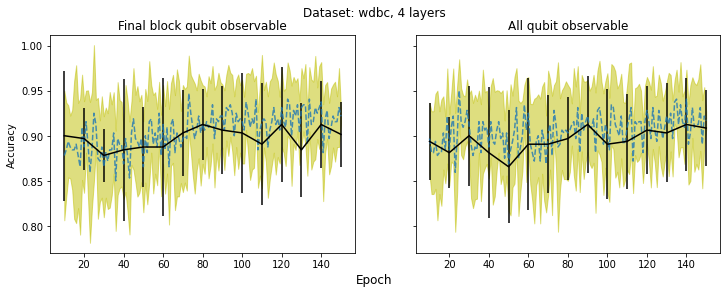

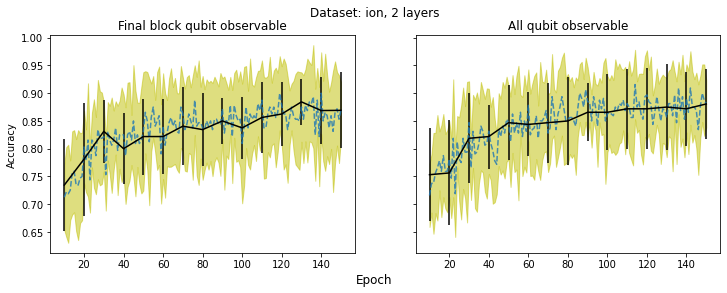

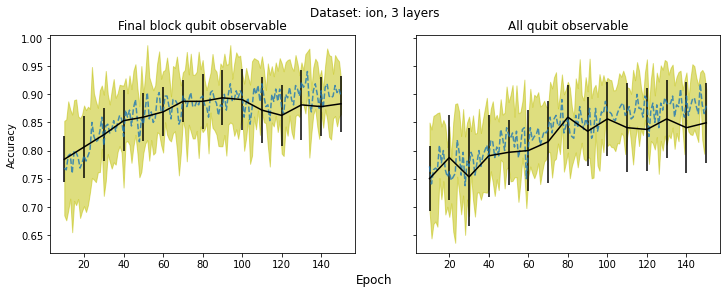

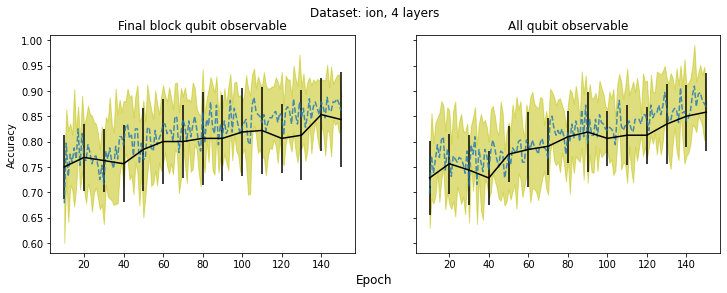

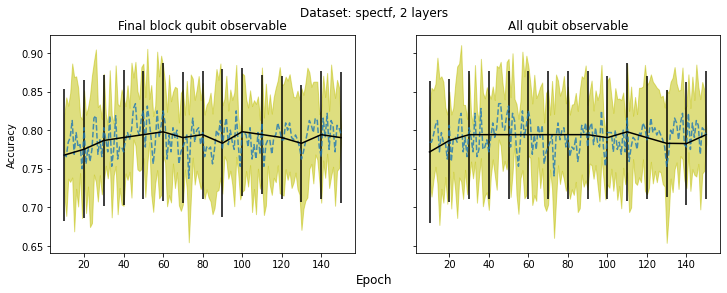

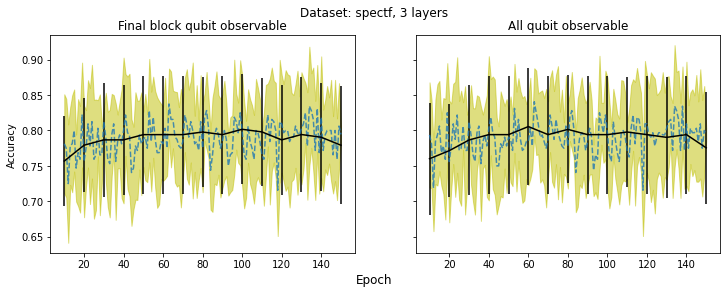

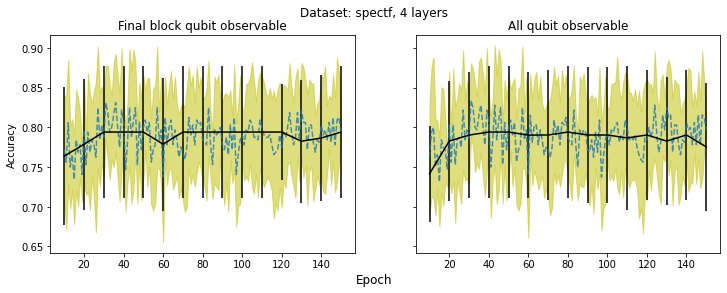

The models below have no entanglement between blocks.


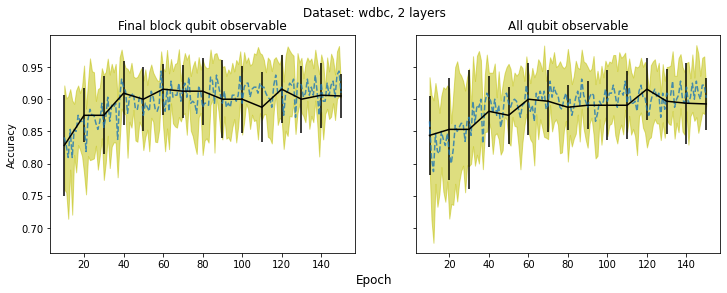

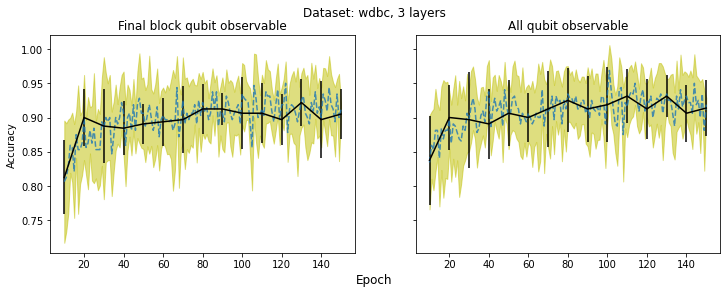

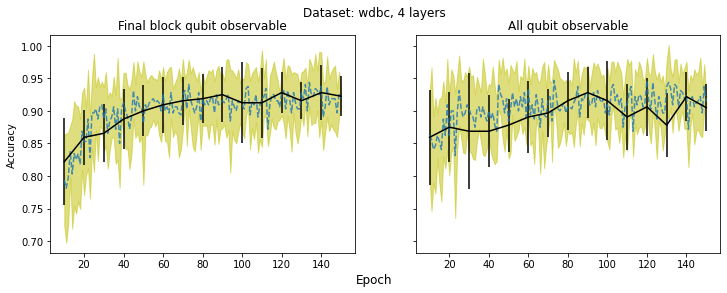

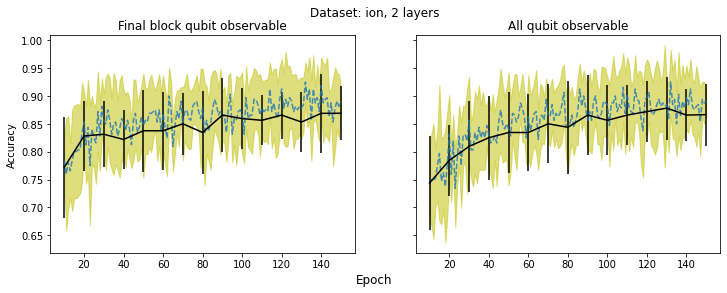

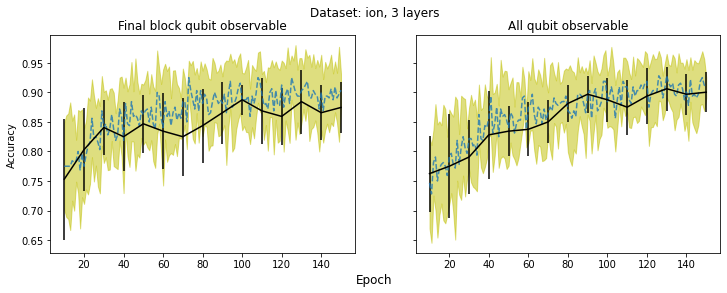

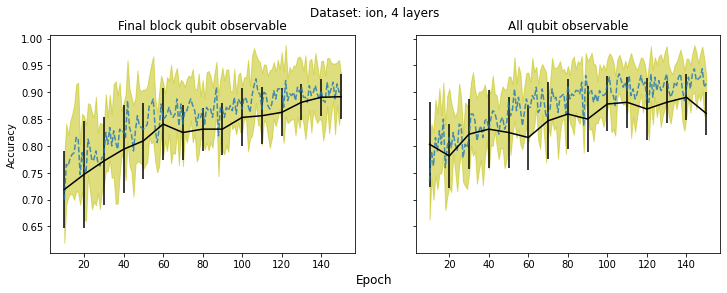

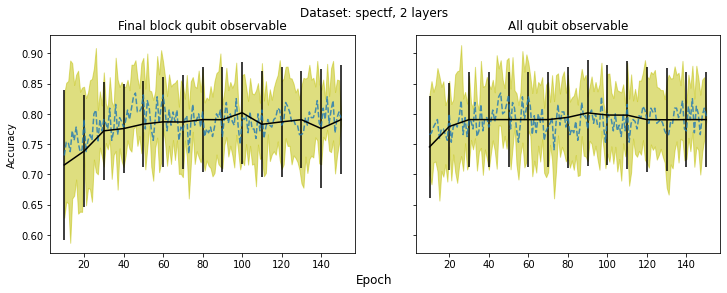

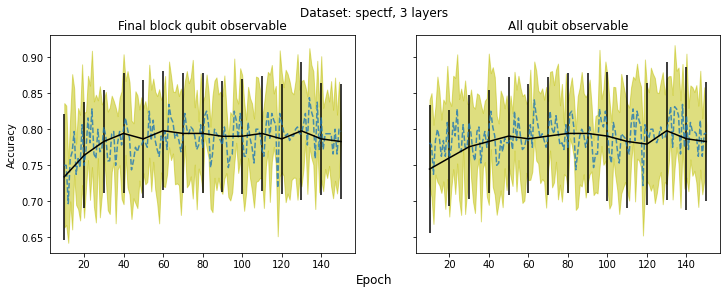

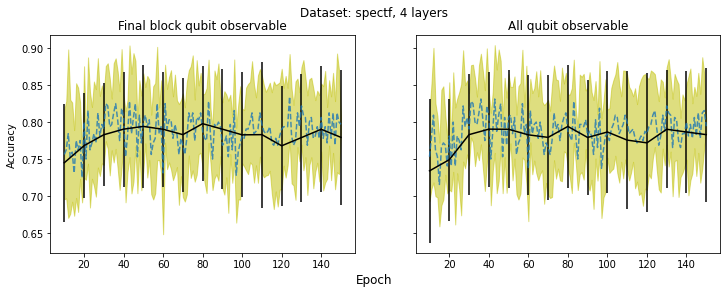

In [7]:
datasets = ["wdbc", "ion", "spectf"]
ent_models = ["PQC-4B", "PQC-4D"]
nent_models = ["PQC-4C", "PQC-4E"]
colors = ["b", "g", "r", "k"]

def label_obs(mod):
    if mod[-1] == "B" or mod[-1] == "C":
        return "Final block qubit observable"
    else:
        return "All qubit observable"
    
def label_ent(mod):
    if mod[-1] == "B" or mod[-1] == "D":
        return "block entanglement"
    else:
        return "no block entanglement"

print("We first show plots of the training and validation accuracy to assess convergence or overfitting." \
     " Later we will better present the differences.")
print("Results for the first 10 epochs are omitted to reduce the y-axis range.")
print("The models below have entanglement between blocks as in Fig 3 but with a number of layers as stated.")
command_train = None

v_x_range = np.arange(10,151, 10)
t_x_range = np.arange(10,151)
#b, q fixed, l is over range [2,3,4]
for d in datasets:
    for l in range(2,5):
        fig1, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,4))
        fig1.suptitle(f"Dataset: {d}, {l} layers")
        ax[0].set_ylabel("Accuracy")
        fig1.supxlabel("Epoch")
        for j, m in enumerate(ent_models):
            v_acc_mean, v_acc_std = [], []
            t_acc_mean, t_acc_std = [], []
            fname = f"runs/Exp15*{d}*{m}-{l}-2-5*.pkl"
            files = glob.glob(fname)
            if len(files) >= 1:
                v_accs = np.zeros((len(files), 15))
                t_accs = np.zeros((len(files), 141))
                for i, f in enumerate(files):
                    pickle_open = open(f, 'rb')
                    run_dict = pickle.load(pickle_open)
                    v_accs[i] = run_dict["validation_accuracy"][1:]
                    t_accs[i] = run_dict["training_acc"][10:]
                ax[j].set_title(f"{label_obs(m)}")
                ax[j].errorbar(v_x_range, np.mean(v_accs, axis=0), yerr=np.std(v_accs, axis=0), fmt="k-")
                #ax[j].errorbar(t_x_range[1::2], np.mean(t_accs, axis=0)[1::2], yerr=np.std(t_accs, axis=0)[1::2], fmt=colors[j]+"--", alpha=0.6)
                ax[j].plot(t_x_range, np.mean(t_accs, axis=0), "--", alpha=0.8)
                ax[j].fill_between(t_x_range, np.mean(t_accs, axis=0)-np.std(t_accs, axis=0), np.mean(t_accs, axis=0)+np.std(t_accs, axis=0), color="y", alpha=0.5)
        plt.show()
        
print("The models below have no entanglement between blocks.")
for d in datasets:
    for l in range(2,5):
        fig1, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,4))
        fig1.suptitle(f"Dataset: {d}, {l} layers")
        ax[0].set_ylabel("Accuracy")
        fig1.supxlabel("Epoch")
        for j, m in enumerate(nent_models):
            v_acc_mean, v_acc_std = [], []
            t_acc_mean, t_acc_std = [], []
            fname = f"runs/Exp15*{d}*{m}-{l}-2-5*.pkl"
            files = glob.glob(fname)
            if len(files) >= 1:
                v_accs = np.zeros((len(files), 15))
                t_accs = np.zeros((len(files), 141))
                for i, f in enumerate(files):
                    pickle_open = open(f, 'rb')
                    run_dict = pickle.load(pickle_open)
                    v_accs[i] = run_dict["validation_accuracy"][1:]
                    t_accs[i] = run_dict["training_acc"][10:]
                ax[j].set_title(f"{label_obs(m)}")
                ax[j].errorbar(v_x_range, np.mean(v_accs, axis=0), yerr=np.std(v_accs, axis=0), fmt="k-")
                #ax[j].errorbar(t_x_range[1::2], np.mean(t_accs, axis=0)[1::2], yerr=np.std(t_accs, axis=0)[1::2], fmt=colors[j]+"--", alpha=0.6)
                ax[j].plot(t_x_range, np.mean(t_accs, axis=0), "--", alpha=0.8)
                ax[j].fill_between(t_x_range, np.mean(t_accs, axis=0)-np.std(t_accs, axis=0), np.mean(t_accs, axis=0)+np.std(t_accs, axis=0), color="y", alpha=0.5)
        plt.show()

In [14]:
datasets = ["wdbc", "ion"]
ent_models = ["PQC-4B", "PQC-4D"]
nent_models = ["PQC-4C", "PQC-4E"]
import pandas as pd

command_train = None

obs_diff, ent_diff = [], []

for d in datasets:
    Ent, Obs, val2, val3, val4 = [],[],[],[],[]
    std2, std3, std4 = [],[],[]
    for j, m in enumerate(ent_models+nent_models):
        if m in ent_models:
            E = True
        else:
            E = False
        if m[-1] == "B" or m[-1] == "C":
            O = "Final"
        else: 
            O = "All"
        Ent.append(E)
        Obs.append(O)
        for l in range(2,5):
            fname = f"runs/Exp15*{d}*{m}-{l}-2-5*.pkl"
            files = glob.glob(fname)
            if len(files) >= 1:
                v_accs = np.zeros((len(files), 1))
                t_accs = np.zeros((len(files), 1))
                for i, f in enumerate(files):
                    pickle_open = open(f, 'rb')
                    run_dict = pickle.load(pickle_open)
                    v_accs[i] = run_dict["validation_accuracy"][-1]
                    t_accs[i] = run_dict["training_acc"][-1] 
                    

            if l==2: 
                val2.append(np.mean(v_accs))
                std2.append(np.std(v_accs))
            if l==3: 
                val3.append(np.mean(v_accs))
                std3.append(np.std(v_accs))
            if l==4: 
                val4.append(np.mean(v_accs))
                std4.append(np.std(v_accs))
                
    print(f"{d} dataset")
    display(pd.DataFrame({"Interblock CNOTs": Ent, "Observable": Obs, 
              "Val Acc L=2": val2, "Std2": std2, "Val Acc L=3": val3, "Std3": std3, "Val Acc L=4": val4, "Std4": std4})
         )
    for val in [val2, val3, val4]:
        obs_diff.append(val[0]-val[1]) #Final - all, ent=True
        obs_diff.append(val[2]-val[3]) #Final - all, ent=False
        ent_diff.append(val[0]-val[2]) #True - False, obs=final
        ent_diff.append(val[1]-val[3]) #True - False, obs=all

wdbc dataset


,Interblock CNOTs,Observable,Val Acc L=2,Std2,Val Acc L=3,Std3,Val Acc L=4,Std4
0,True,Final,0.922588,0.024223,0.906798,0.039440,0.901504,0.036424
1,True,All,0.894486,0.048552,0.906798,0.039440,0.908521,0.042403
2,False,Final,0.905044,0.033661,0.904981,0.036624,0.922588,0.030921
3,False,All,0.892669,0.040130,0.913816,0.041308,0.905013,0.035593


ion dataset


,Interblock CNOTs,Observable,Val Acc L=2,Std2,Val Acc L=3,Std3,Val Acc L=4,Std4
0,True,Final,0.869127,0.068512,0.883175,0.050251,0.843492,0.093649
1,True,All,0.880635,0.062568,0.849365,0.070888,0.858016,0.076887
2,False,Final,0.868889,0.048272,0.874524,0.042990,0.891667,0.042127
3,False,All,0.866429,0.055701,0.900317,0.034286,0.860556,0.040524


From the tables above we can make the following conclusions:
1) The error bars dominate the like for like difference in validation accuracy between the final and all qubit observables. \
2) The addition of interblock CNOTs has no noticable effect the validation accuracy, as again the error bars dominate. 

In [23]:
print("Supporting evidence:")
print(f"1) The mean difference in validation accuracy between the final and all qubit observable" \
      f" across the settings presented above is {np.mean(obs_diff):.3}")
print(f"2) The mean difference in validation accuracy between the entangled and non-entangled block models" \
      f" across the settings presented above is {np.mean(ent_diff):.3}")


Supporting evidence:
1) The mean difference in validation accuracy between the final and all qubit observable across the settings presented above is 0.00481
1) The mean difference in validation accuracy between the entangled and non-entangled block models across the settings presented above is -0.00683


As there is no empirical difference between an all-qubit and final-qubit observable, we repeat the experiment on some artificial datasets. The first is the output of our circuit ansatz with randomly initialized parameters, and the second is the critical traverse field Ising model, given by $H = \sum_{j}^{N-1}Z_{j}Z_{j+1} + \sum_{j}X_{j}$

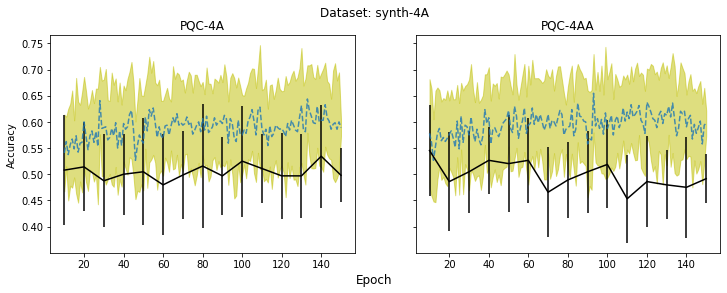

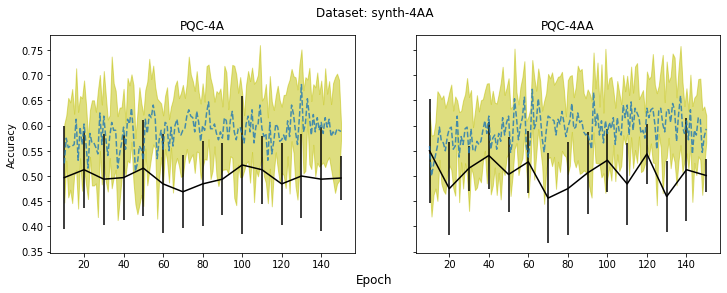

In [31]:
datasets = ["synth-4A", "synth-4AA"]
models = ["PQC-4A", "PQC-4AA"]
command_train = None

v_x_range = np.arange(10,151, 10)
t_x_range = np.arange(10,151)
#b, q fixed, l is over range [2,3,4]
for d in datasets:
    fig1, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,4))
    fig1.suptitle(f"Dataset: {d}")
    ax[0].set_ylabel("Accuracy")
    fig1.supxlabel("Epoch")
    for j, m in enumerate(models):
        v_acc_mean, v_acc_std = [], []
        t_acc_mean, t_acc_std = [], []
        fname = f"runs/Exp17*{d}*{m}-4-2-5*.pkl"
        files = glob.glob(fname)
        if len(files) >= 1:
            v_accs = np.zeros((len(files), 15))
            t_accs = np.zeros((len(files), 141))
            for i, f in enumerate(files):
                pickle_open = open(f, 'rb')
                run_dict = pickle.load(pickle_open)
                v_accs[i] = run_dict["validation_accuracy"][1:]
                t_accs[i] = run_dict["training_acc"][10:]
            ax[j].set_title(f"{m}")
            ax[j].errorbar(v_x_range, np.mean(v_accs, axis=0), yerr=np.std(v_accs, axis=0), fmt="k-")
            #ax[j].errorbar(t_x_range[1::2], np.mean(t_accs, axis=0)[1::2], yerr=np.std(t_accs, axis=0)[1::2], fmt=colors[j]+"--", alpha=0.6)
            ax[j].plot(t_x_range, np.mean(t_accs, axis=0), "--", alpha=0.8)
            ax[j].fill_between(t_x_range, np.mean(t_accs, axis=0)-np.std(t_accs, axis=0), np.mean(t_accs, axis=0)+np.std(t_accs, axis=0), color="y", alpha=0.5)
    plt.show()

In [32]:
datasets = ["synth-4A", "synth-4AA"]
models = ["PQC-4A", "PQC-4AA"]
t_tab = np.zeros((2,2))
v_tab = np.zeros((2,2))

for p, d in enumerate(datasets):
    for q, m in enumerate(models):
        fname = f"runs/Exp17*{d}-*-{m}-4-2-5*.pkl"
        files = glob.glob(fname)
        if len(files) > 0:
            v_accs = np.zeros((len(files), 1))
            t_accs = np.zeros((len(files), 1))
            for i, f in enumerate(files):
                pickle_open = open(f, 'rb')
                run_dict = pickle.load(pickle_open)
                v_accs[i] = run_dict["validation_accuracy"][-1]
                t_accs[i] = run_dict["training_acc"][-1]
            t_tab[p,q] = np.mean(t_accs)
            v_tab[p,q] = np.mean(v_accs)
print(t_tab)
print(v_tab)
          
        


[[0.5898 0.6016]
 [0.5882 0.5934]]
[[0.5   0.482]
 [0.496 0.501]]


*Number of layers* <br>
As mentioned above, a core block of the circuit can be repeated for a certain number of layers. Each additional layer increases the expressivity of the model. Define $\mathcal{F}_{W, L}= \{\mathcal{f}_{\Theta}(x) = \}$

It is easy to see that $W^{L} \subset W^{L+2}$ by setting $\theta_{L+1}$ and $\theta_{L+2}$ to zero, leaving the CNOTs to cancel each other out.

In [2]:
print(f"\pm")

\pm
